In [29]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(monocle3))
suppressPackageStartupMessages(library(harmony))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(viridisLite))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(data.table))
packageVersion("monocle3")
set.seed(0)

[1] ‘1.3.1’

### Load all data necessary for Fig6

1. Load metadata with astrocyte subcluster label for each cell (astH1, astR1, etc.,)

In [3]:
all_metaData <- read.csv('/autofs/space/mindds_001/projects/AbbvieSnRNASeq/data/trajectory_analysis_2023/merged_metadata.csv')
rownames(all_metaData) <- all_metaData$X
clust_grp <- all_metaData[,c('X','cluster_group')]

2. Seurat object with astrocytes sub-sampled by each region and stage (3000 per, in total 60,000)

In [4]:
obj <- readRDS('./merged_60000x39123_0418.RDS')
ast = CreateSeuratObject(counts = obj@assays[['RNA']]@counts, 
                         meta.data = obj@meta.data[c('SampleName','Unified_region','Donor.ID','Path..Group.')],
                         project = "ast", min.cells = 20)
rm(obj)

### Integration by SampleName with harmony

In [5]:
# pca for Harmony
ast <- ast %>%
  Seurat::NormalizeData(verbose = FALSE) %>%
  FindVariableFeatures(selection.method = "vst", nfeatures = 2000) %>% 
  ScaleData(verbose = FALSE) %>% 
  RunPCA(pc.genes = ast@var.genes, npcs = 20, verbose = FALSE)

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2185100)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 43702
Number of edges: 1146765

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8889
Number of communities: 10
Elapsed time: 5 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:02:39 UMAP embedding parameters a = 0.9922 b = 1.112

21:02:39 Read 43702 rows and found 20 numeric columns

21:02:39 Using Annoy for neighbor search, n_neighbors = 30

21:02:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:02:43 Writing NN index file to temp file /scratch/RtmpRFZxTd/file1b729325ad4e34

21:02:43 Searching Annoy index using 1 thread, search_k = 3000

21:02:57 Annoy recall = 100%

21:02:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neig

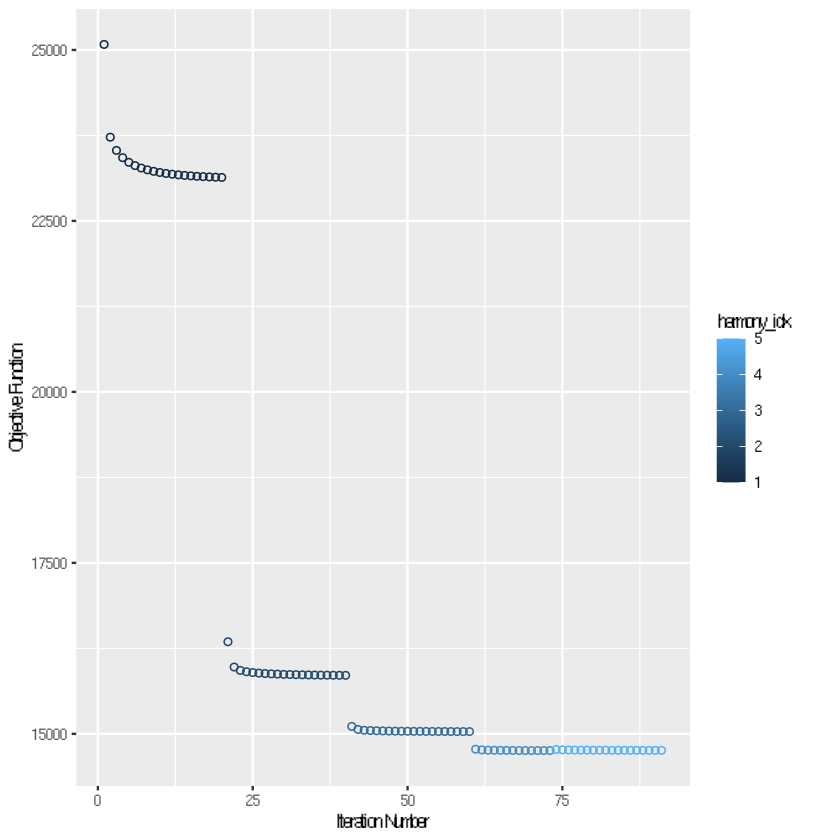

In [6]:
### Integration with harmony
ast <- ast[,rownames(ast@meta.data) %in% rownames(clust_grp)]
ast <- ast %>% 
  RunHarmony("SampleName", plot_convergence = TRUE, lambda = 1) %>% 
  FindNeighbors(reduction = "harmony", dims = 1:20) %>% 
  FindClusters(resolution = 0.3) %>% 
  RunUMAP(reduction = "harmony", dims = 1:20, seed.use = 42) %>% 
  identity()

### Fig6a, UMAP plot

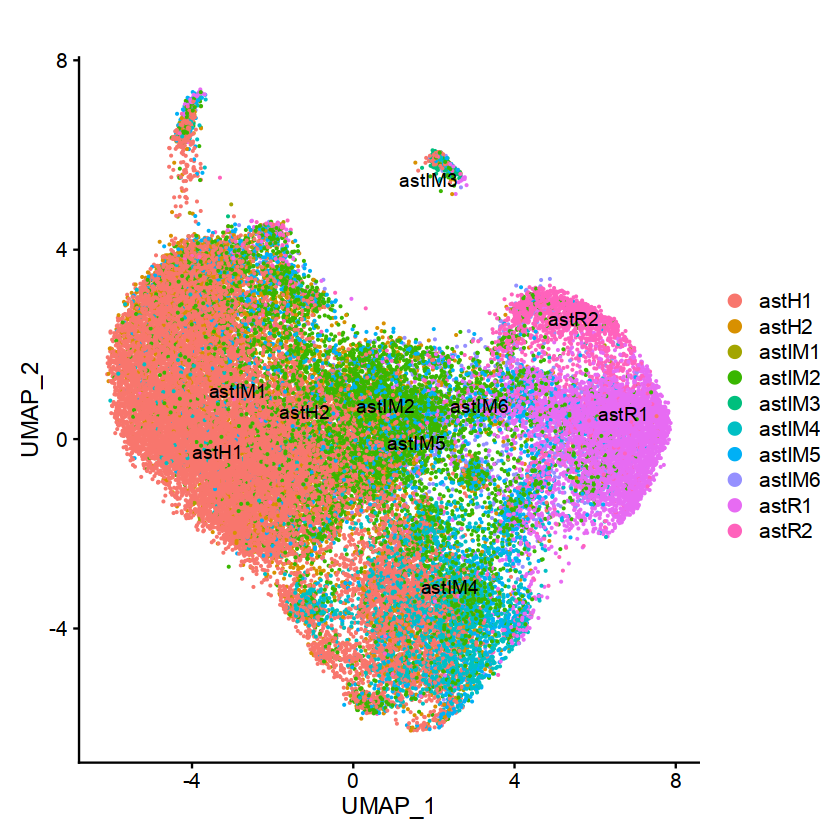

In [9]:
ast@meta.data$Ast_clust <- clust_grp[rownames(ast@meta.data),'cluster_group']
p1 <- DimPlot(object = ast, reduction = "umap", pt.size = .1, group.by = "seurat_clusters")
p2 <- DimPlot(object = ast, reduction = "umap", pt.size = .1, group.by = "Ast_clust") + 
  theme(text=element_text(size=14,  family="Arial")) +
  ggtitle('')
LabelClusters(plot=p2, id = 'Ast_clust', size = 4, family='Arial')

### Fig6a, UMAP plot

In [18]:
ast@meta.data$UMAP1 <- Embeddings(ast, "umap")[,1]
ast@meta.data$UMAP2 <- Embeddings(ast, "umap")[,2]
dat <- data.frame(ast@meta.data)
dat$Sample <- do.call(paste, c(dat[c('Path..Group.','Unified_region')], sep="-"))
dat$Sample <- str_replace(dat$Sample, "1-EC", "EC-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-EC", "EC-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-EC", "EC-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-EC", "EC-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-BA20", "ITG-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-BA20", "ITG-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-BA20", "ITG-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-BA20", "ITG-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-BA46", "PFC-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-BA46", "PFC-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-BA46", "PFC-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-BA46", "PFC-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-V2", "V2-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-V2", "V2-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-V2", "V2-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-V2", "V2-PathStage4")
dat$Sample <- str_replace(dat$Sample, "1-V1", "V1-PathStage1")
dat$Sample <- str_replace(dat$Sample, "2-V1", "V1-PathStage2")
dat$Sample <- str_replace(dat$Sample, "3-V1", "V1-PathStage3")
dat$Sample <- str_replace(dat$Sample, "4-V1", "V1-PathStage4")
dat$Sample <- factor(dat$Sample, levels=paste0(c('EC','ITG','PFC','V2','V1'),
                                               '-PathStage',
                                               c(rep(1,5),rep(2,5),rep(3,5),rep(4,5))))

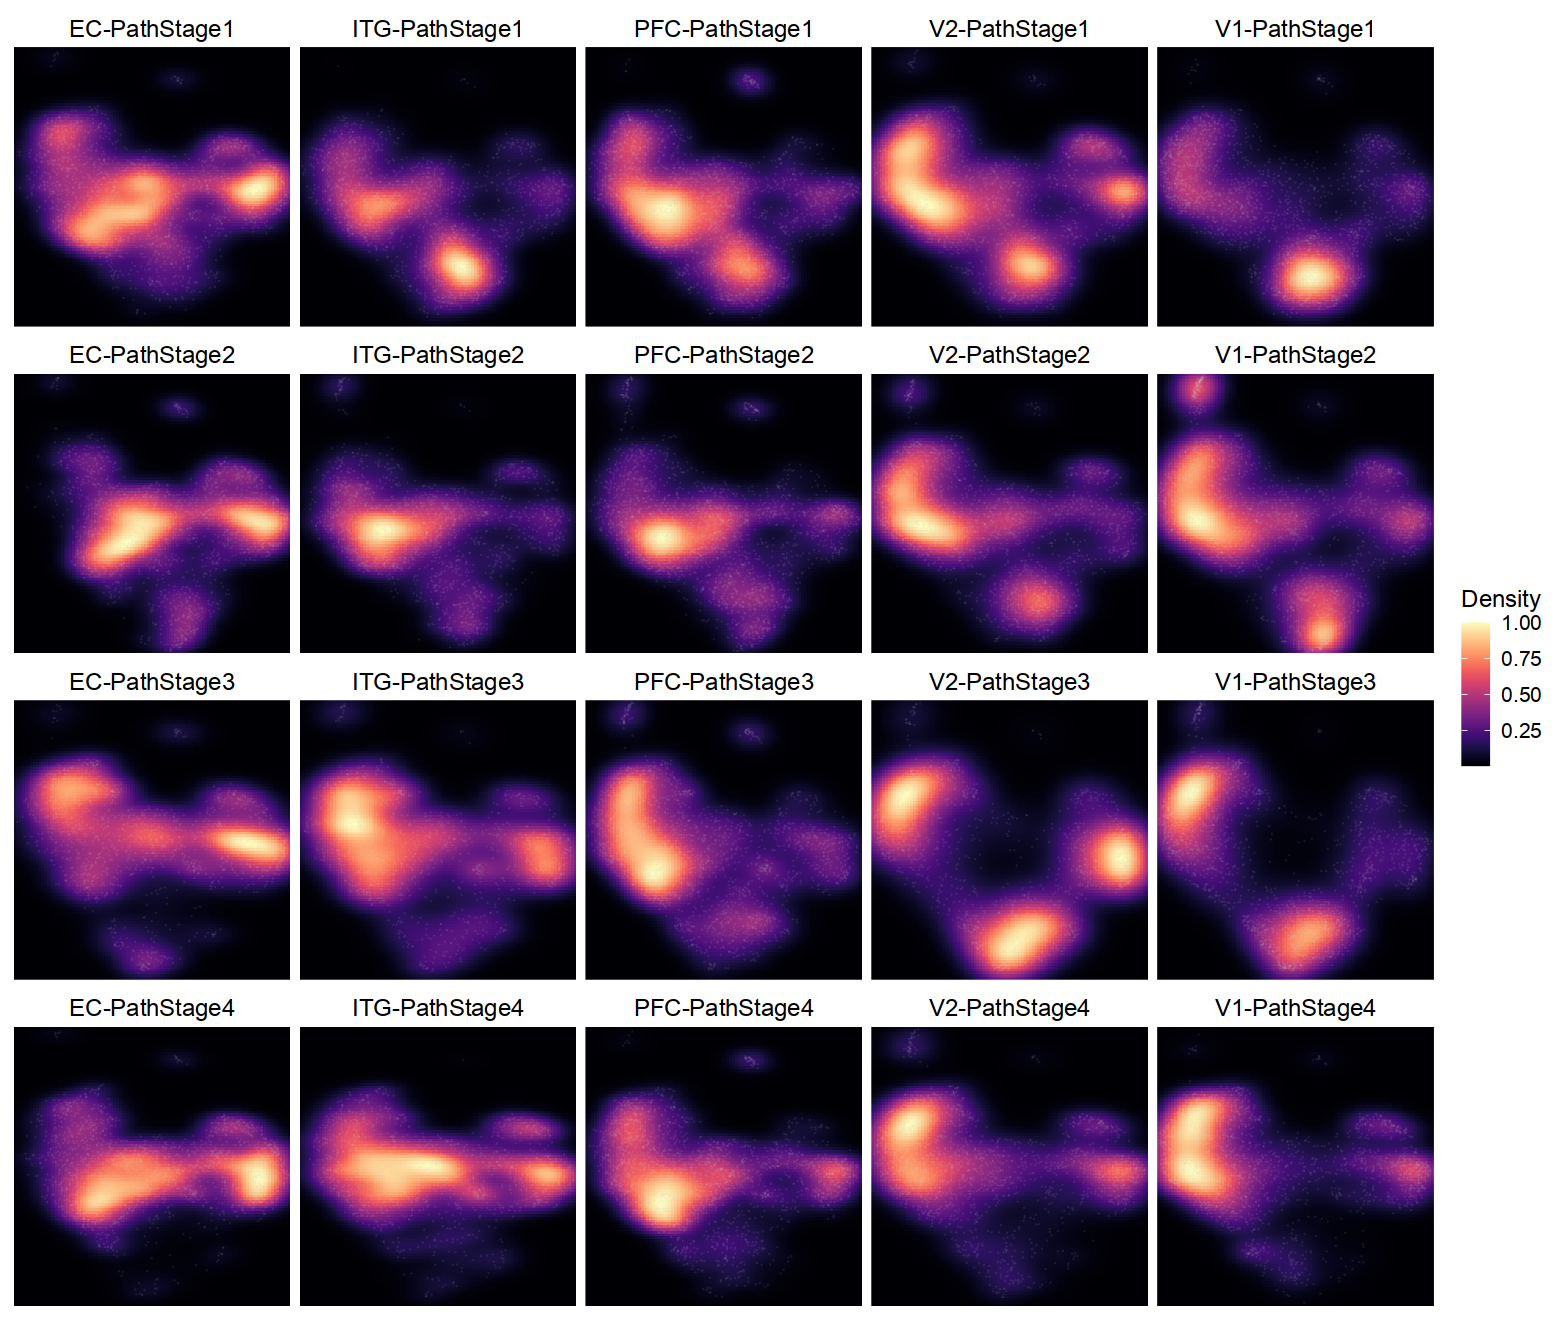

In [19]:
density_plot <- ggplot(dat, aes(x=UMAP1, y=UMAP2)) +
  stat_density_2d(geom="raster", aes(fill=after_stat(ndensity)), contour=F, bins=100, alpha=100) + 
  geom_point(data=dat, shape=16, size=0, alpha=0.1, color="lightgrey") +
  scale_fill_gradientn(colours=viridisLite::magma(200), name="Density") +
  scale_x_continuous(expand=c(0,0)) +
  scale_y_continuous(expand=c(0,0)) +
  facet_wrap(~Sample, ncol=5) +
  #xlim(-4,6) + ylim(-4,6) + 
  theme_classic() +
  theme(strip.background = element_blank(),
        strip.text = element_text(size=14, color="black",family="Arial"),
        axis.text=element_blank(),
        axis.title=element_blank(),
        axis.ticks=element_blank(),
        axis.line = element_blank(),
        plot.background = element_rect(fill = "transparent", color = NA),
        legend.text=element_text(size=12, color="black",family="Arial"),
        legend.title=element_text(size=14, color="black",family="Arial"))
options(repr.plot.height = 11, repr.plot.width = 13)
density_plot

### Fig6b, trajectory by Monocle3

In [20]:
# a helper function to identify the root principal points:
get_earliest_principal_node <- function(cds, time_bin='astH1'){
  cell_ids <- which(colData(cds)[, "cell_type"] == time_bin)
  
  closest_vertex <- cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
    igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
                                                              (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

In [21]:
# gene annotation
gene_annotation <- as.data.frame(rownames(ast@reductions[["pca"]]@feature.loadings), 
                                 row.names = rownames(ast@reductions[["pca"]]@feature.loadings))
colnames(gene_annotation) <- "gene_short_name"

# cell annotation
cell_metadata <- as.data.frame(ast@assays[["RNA"]]@counts@Dimnames[[2]], 
                               row.names = ast@assays[["RNA"]]@counts@Dimnames[[2]])
colnames(cell_metadata) <- "barcode"

In [22]:
# cds object
New_matrix <- ast@assays[["RNA"]]@counts
New_matrix <- New_matrix[rownames(ast@reductions[["pca"]]@feature.loadings), ]
expression_matrix <- New_matrix
cds_from_seurat <- new_cell_data_set(expression_matrix,
                                     cell_metadata = cell_metadata,
                                     gene_metadata = gene_annotation)

In [23]:
# Construct and assign the made up partition
recreate.partition <- c(rep(1, length(cds_from_seurat@colData@rownames)))
names(recreate.partition) <- cds_from_seurat@colData@rownames
recreate.partition <- as.factor(recreate.partition)

cds_from_seurat@clusters@listData[["UMAP"]][["partitions"]] <- recreate.partition

In [24]:
# Assign the cluster info
cluster.res <- 0.3
nPC <- 20
ast[[sprintf("ClusterNames_%.1f_%dPC", cluster.res, nPC)]] <- Idents(object = ast)
list_cluster <- ast@meta.data[[sprintf("ClusterNames_%s_%sPC", cluster.res, nPC)]]
names(list_cluster) <- ast@assays[["RNA"]]@data@Dimnames[[2]]

cds_from_seurat@clusters@listData[["UMAP"]][["clusters"]] <- list_cluster
# Could be a space-holder, but essentially fills out louvain parameters
cds_from_seurat@clusters@listData[["UMAP"]][["louvain_res"]] <- "NA"
# Assign UMAP coordinate
cds_from_seurat@int_colData@listData$reducedDims@listData[["UMAP"]] <-ast@reductions[["umap"]]@cell.embeddings 

In [25]:
# Learn graph, this step usually takes a significant period of time for larger samples
print("Learning graph, which can take a while depends on the sample")
cds_from_seurat <- learn_graph(cds_from_seurat, use_partition = T)
colData(cds_from_seurat)$seurat_clusters <- ast@meta.data[rownames(colData(cds_from_seurat)),]$seurat_clusters
colData(cds_from_seurat)$cell_type <- ast@meta.data[rownames(colData(cds_from_seurat)),]$Ast_clust
cds_from_seurat <- order_cells(cds_from_seurat, 
                               root_pr_nodes = get_earliest_principal_node(cds_from_seurat))

[1] "Learning graph, which can take a while depends on the sample"
  |======================================================================| 100%


Cells aren't colored in a way that allows them to be grouped.



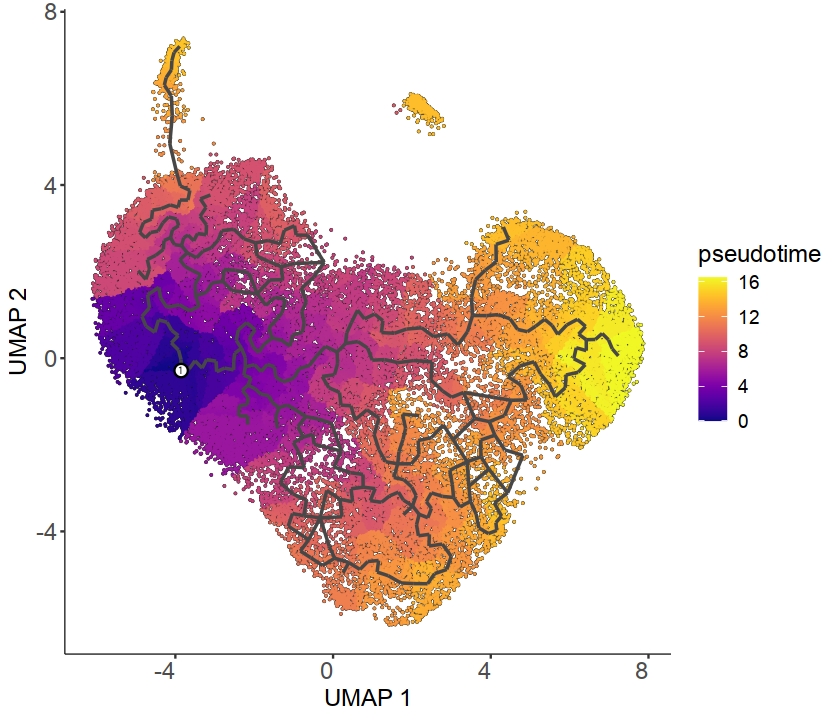

In [28]:
# plot
ptime <- plot_cells(cds_from_seurat, 
                    color_cells_by = 'pseudotime',
                    label_cell_groups = TRUE,
                    label_groups_by_cluster=TRUE,
                    label_leaves=FALSE,
                    label_branch_points=FALSE) + 
  theme(text=element_text(size=14,  family="Arial")) +
  theme(axis.text = element_text(size = 14, hjust = 1))
options(repr.plot.width = 7, repr.plot.height = 6)
ptime

### fig6c, Heatmap along pseudotime

In [40]:
cds <- cds_from_seurat
colData(cds)$SampleName <- ast@meta.data[rownames(colData(cds)),]$SampleName
colData(cds)$Donor.ID <- ast@meta.data[rownames(colData(cds)),]$Donor.ID

In [32]:
# genes change along pseudotime/graph
pr_graph_test_res <- graph_test(cds, neighbor_graph="knn", cores=8)
pr_deg_ids <- row.names(subset(pr_graph_test_res, q_value < 1e-30))
length(pr_deg_ids)

  |=======================================================| 100%, Elapsed 00:22


[1] 1233

In [33]:
# Markers to be labeled on Heatmap
h1h2 = c('ALDH1L1','CD47','EGFR','EGLN3','ERBB4','GJA1','GLUL','GRM3',
         'HIF3A','LRP1','MEGF10','NFIA','NFIB','NRXN1','NTRK3','PON2',
         'PTN','RYR3','SLC1A2','SLC1A3','SYNE1')
r1r2 = c('ACTB','APP','AQP4','CD44','CLU','CRYAB','ECE1','FGFR1',
         'GFAP','HSPB1','HSPB8','LAMA1','MAOB','MAP1B','MAPT','MT1E',
         'MT2A','PRDX6','S100B','VCAN')
asp_add = c('HSPH1','SERPINA3','ABCA1','C3')

In [34]:
genes <- c(h1h2,r1r2,pr_deg_ids)
genes <- genes[genes %in% rownames(ast)]
length(genes)

[1] 1274

In [35]:
map = c('astH','astH','astIM','astIM','astIM','astIM','astIM','astIM','astR','astR')
names(map) = c('astH1','astH2','astIM1','astIM2','astIM3','astIM4','astIM5','astIM6','astR1','astR2')

In [41]:
# subset of cds
cds <- cds[,sample(dim(cds)[2],5000)]
order_ = order(pseudotime(cds))
cds@colData$Clust <- map[cds@colData$cell_type]
cds@colData$pseudotime <- pseudotime(cds)[rownames(cds@colData)]
colData <- cds@colData[order_,]

In [42]:
# heatmap column annot: cell subcluster
ann <- data.frame(colData$Clust)
colnames(ann) <- c('Clusters')
colours <- list('Clusters' = c("astH" = "lightblue", "astIM" = "orange", "astR" = "red"))
colAnn <- HeatmapAnnotation(
  df = data.frame(ann),
  which = 'col',
  col = colours,
  annotation_width = unit(c(1, 4), 'cm'),
  gap = unit(1, 'mm'),
  show_legend = FALSE,
  show_annotation_name = T)

In [43]:
# heatmap column annot: pseudotime
ann_ <- data.frame(colData$pseudotime)
colnames(ann_) <- c('Pseudotime')
min_v = min(colData$pseudotime)
max_v = max(colData$pseudotime)
nrow = dim(ann_)[1]
Var = viridisLite::magma(nrow)#circlize::colorRamp2(seq(min_v, max_v, length = nrow), viridisLite::viridis(nrow))
names(Var) <- colData$pseudotime
pseudotime_annot = HeatmapAnnotation(df = ann_,
                                     col = list('Pseudotime'=Var),
                                     which = "col",
                                     show_legend = FALSE,
                                     show_annotation_name = T)

In [44]:
# heatmap matrix
order_ = order(pseudotime(cds))
order_cells_ = names(pseudotime(cds)[order_])
mat_ <- as.matrix(ast@assays[['RNA']]@counts[match(genes, rownames(ast)),order_cells_])
pt.matrix <- mat_
pt.matrix <- t(apply(pt.matrix,1,function(x){smooth.spline(x,df=5)$y}))
pt.matrix <- t(apply(pt.matrix,1,function(x){(x-mean(x))/sd(x)}))
rownames(pt.matrix) <- genes
colnames(pt.matrix) <- colnames(mat_)
dim(pt.matrix)

[1] 1274 5000

In [45]:
# check
identical(rownames(colData), colnames(pt.matrix)); identical(rownames(pt.matrix), genes)

[1] TRUE

[1] TRUE

In [46]:
# reorder rows by column max from left to right
gene_list=c()
argmax_cell=c()
for (i in seq(1,dim(pt.matrix)[1])){
  gene_list = c(gene_list, rownames(pt.matrix)[i])
  argmax_cell = c(argmax_cell, names(which.max(pt.matrix[i,])))
} 
resort_mat = data.frame('gene'=gene_list,
                        'argmax_cell'=argmax_cell,
                        'pseudotime'=pseudotime(cds)[argmax_cell])
resort_genes = resort_mat[order(resort_mat$pseudotime, decreasing = F),]$gene

In [47]:
# heatmap color
hp_color = colorRamp2(seq(from=-2,to=2,length=11),rev(brewer.pal(11, "Spectral")))#RdBu
hp_color_pt = colorRamp2(seq(from=min(pseudotime(cds)),to=max(pseudotime(cds)),length=11),
                         rev(colorRampPalette(brewer.pal(11, "RdYlBu"))(11)))

In [48]:
# Legend
lgd = packLegend(
  Legend(title = "Z-score", at = c(-2, 0, 2), 
         legend_gp = gpar(fill = -2:2),
         col_fun = hp_color,
         title_gp = gpar(fontsize = 12), 
         labels_gp = gpar(fontsize = 12)),
  Legend(title = "Clusters", 
         at = names(colours$Clust), 
         legend_gp = gpar(fill = colours$Clust)))

In [49]:
pt.matrix = pt.matrix[resort_genes,]
pt.matrix = pt.matrix[!duplicated(rownames(pt.matrix)),]
pt.matrix = pt.matrix[!rownames(pt.matrix) %in% c('MT-ATP6','MT-CO1','MT-CO2','MT-CO3',
                                                  'MT-ND1','MT-ND2','MT-ND3','MT-ND4','MT-ND5',
                                                  'MT-CYB','MT-ND4L'),]

In [50]:
h_m = h1h2
r_m = c(r1r2,asp_add)
label_color1 = rep('blue',length(h1h2))
names(label_color1) <- c(h1h2)
label_color2 = rep('red',length(r_m))
names(label_color2) <- c(r_m)
label_color = c(label_color1,label_color2)

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



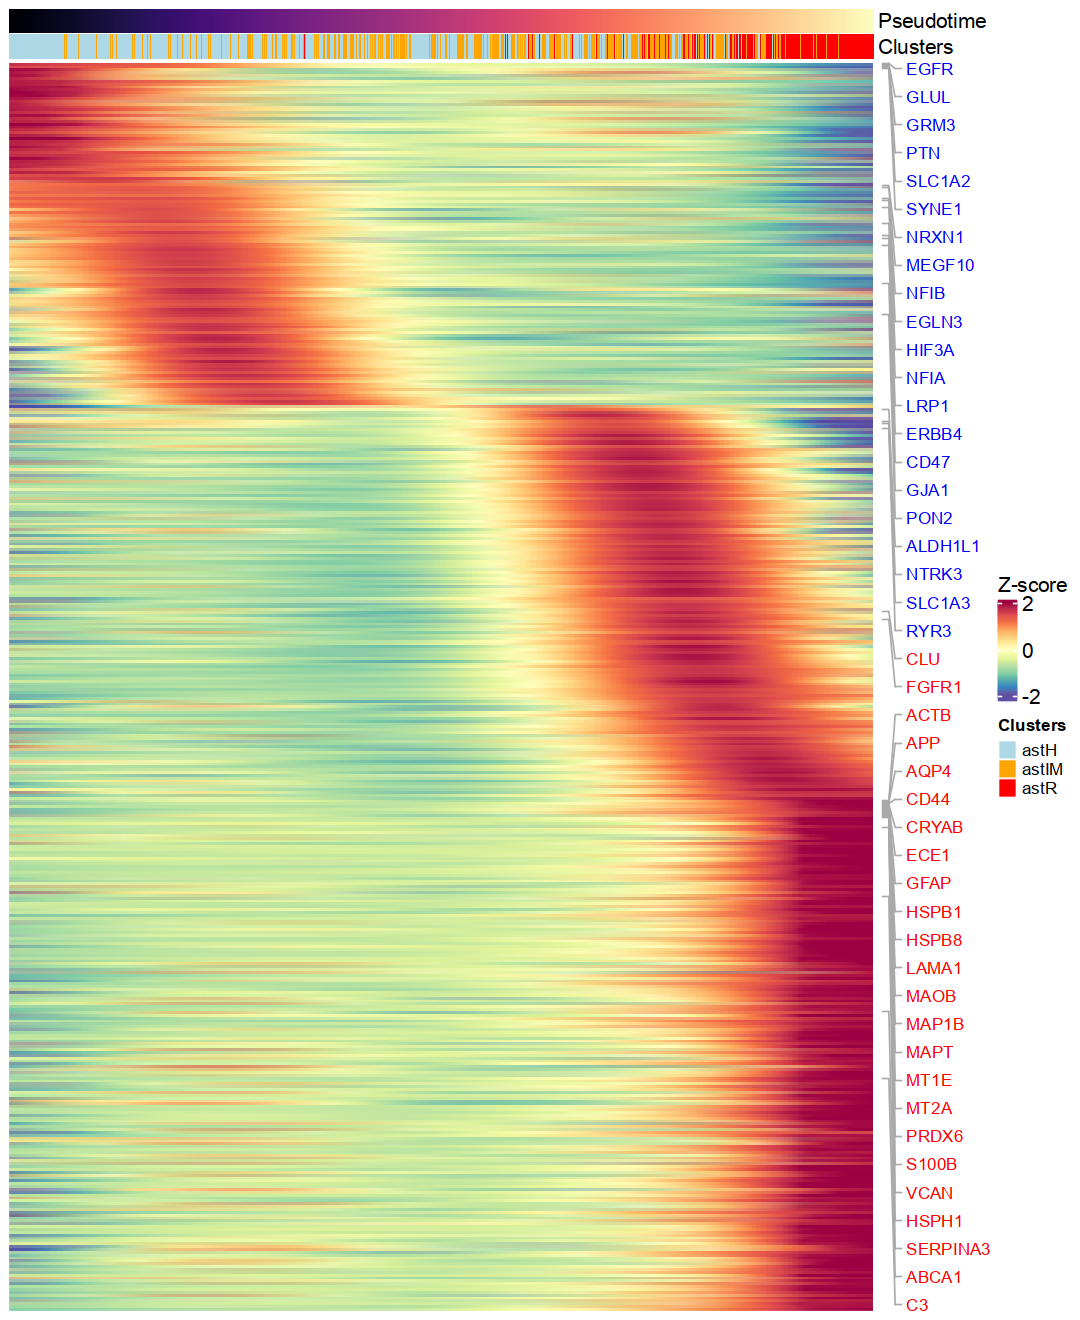

In [51]:
options(repr.plot.width=9, repr.plot.height=11)
pushViewport(viewport(gp = gpar(fontfamily = "Arial")))
ht <- Heatmap(
  pt.matrix,
  ### row cluster
  cluster_rows                 = FALSE, #row_dend, 
  show_row_dend                = FALSE,
  cluster_row_slices           = FALSE,
  cluster_columns              = FALSE,
  show_row_names               = FALSE,
  show_column_names            = FALSE,
  row_names_gp                 = gpar(fontsize = 6),
  #km                           = 3,
  row_title_rot                = 90,
  top_annotation               = c(pseudotime_annot, colAnn),
  col                          = hp_color,
  show_heatmap_legend          = FALSE) + 
  rowAnnotation(link = anno_mark(at = which(rownames(pt.matrix) %in% c(h_m,r_m)), 
                labels = rownames(pt.matrix)[which(rownames(pt.matrix) %in% c(h_m,r_m))], #c(h_m,r_m), 
                labels_gp = gpar(fontsize = 10,
                                 col=label_color[rownames(pt.matrix)[which(rownames(pt.matrix) %in% c(h_m,r_m))]]), 
                lines_gp = gpar(col='darkgrey'),
                padding = unit(1, "mm")))

ht <- draw(ht, 
           annotation_legend_list = lgd, 
           newpage = FALSE, 
           merge_legend = TRUE)
popViewport()